In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import sklearn
from helpers import *

In [2]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [3]:
actors = actors_load.copy()
movies = movies_load.copy()

In [4]:
actors_exp = explode_on_movies(actors)

In [5]:
# Merge actors_exp DataFrame with selected columns from movies DataFrame and sort chronologically
actors_movies = actors_exp.merge(
    movies[["fbID", "genres", "releaseMonth", "releaseYear"]], how="left", on="fbID"
)
actors_movies_sort = actors_movies.sort_values(
    by=["fbActorID", "ageAtMovieRelease", "releaseYear", "releaseMonth"]
)

# Filter actors with at least 20 movies
actors_min_movies = actors_movies_sort.query("numMovies >= 20")

# Remove rows where both ageAtMovieRelease and releaseYear are NaN and where genres is NaN
actors_filter = actors_min_movies[
    ~(actors_min_movies.ageAtMovieRelease.isna() & actors_min_movies.releaseYear.isna())
    & ~actors_min_movies.genres.isna()
].copy()

# Create a new column "genresLen" representing the number of the genres for each movie
actors_filter["genresLen"] = actors_filter.genres.apply(lambda x: len(x))

# Create a new column "LastMovie" indicating whether it's the last movie for each actor
actors_filter["LastMovie"] = np.array(
    [*(actors_filter.fbActorID[1:].values != actors_filter.fbActorID.values[:-1]), True]
)

# Get list of genres in order of occurrences
genreslist = actors_filter.genres.explode().value_counts().index

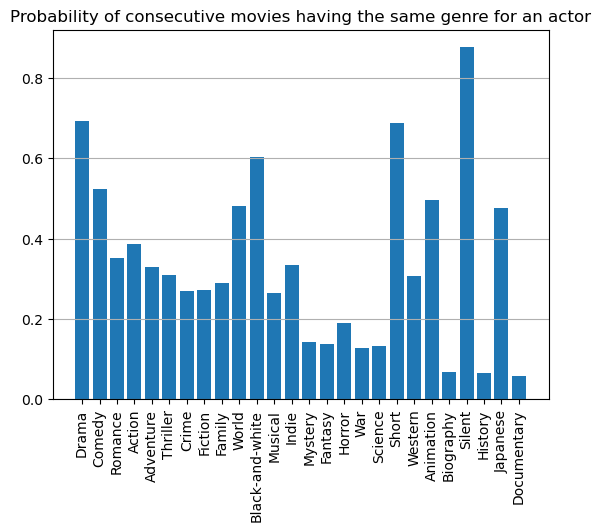

In [6]:
# Create a new DataFrame 'df_genres' containing genre columns and reset index to be able to iterate
df_genres = actors_filter[["genres", "genresLen", "LastMovie"]].reset_index(
    drop=True
)

# Count the occurrences of genres in movies that are not the last for each actor
genres_counts = df_genres[~df_genres["LastMovie"]].genres.explode().value_counts()

# Create a dictionary mapping genres to their corresponding index based on their order of occurrences
index_genres = dict(zip(genres_counts.index, np.arange(len(genreslist))))

# Initialize an array to track the number of times each genre is kept by an actor for two consecutive movies
genre_kept = np.zeros(len(genreslist))

for index, row in df_genres.iterrows():
    # Check if it's not the last movie for the actor
    if not row["LastMovie"]:
        # Find the intersection of genres between the current and next movie
        genre_intersection = row["genres"].intersection(
            df_genres["genres"].iloc[index + 1]
        )
        # If there is an intersection, update genre_kept array
        if len(genre_intersection) != 0:
            for genre in genre_intersection:
                genre_kept[index_genres[genre]] += 1

# Plot a bar chart showing the proportion of each genre kept
plt.figure()
plt.bar(genreslist, genre_kept / genres_counts)
plt.xticks(rotation=90)
plt.title("Probability of consecutive movies having the same genre for an actor")
plt.grid(axis="y")

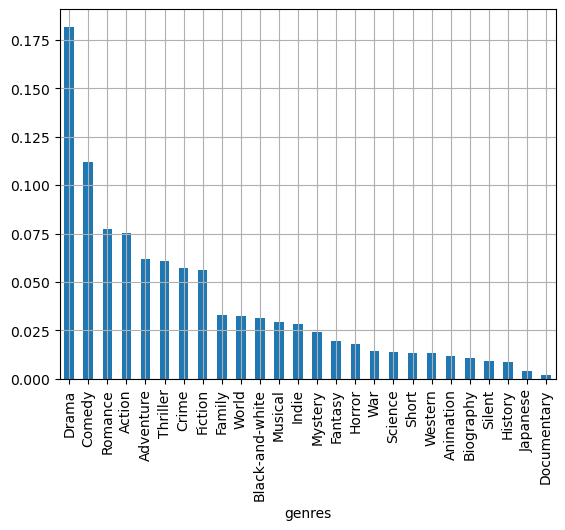

In [33]:
actors_filter.genres.explode().value_counts(normalize=True).plot(kind="bar")
plt.grid()

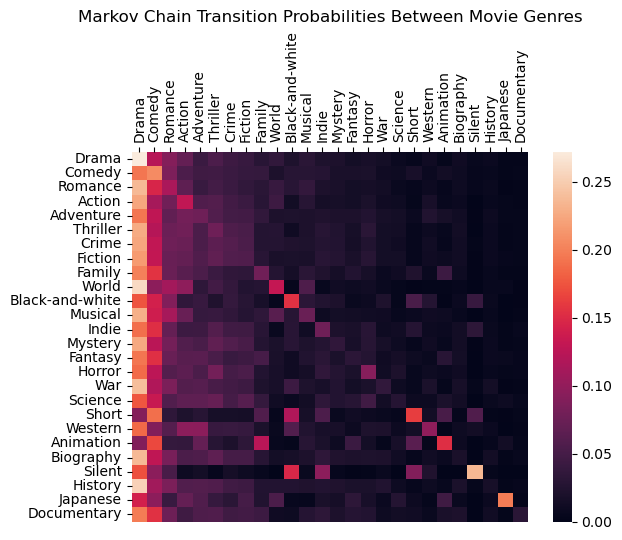

In [30]:
# Initialize a square matrix M to represent the Markov chain transition probabilities
M = np.zeros((len(index_genres), len(index_genres)))

# Iterate through rows of df_genres
for index, row in df_genres.iterrows():
    # Check if it's not the last movie for the actor
    if not row["LastMovie"]:
        # Find the intersection of genres between the current and next movie
        genre_intersection = row["genres"].intersection(df_genres["genres"].iloc[index + 1])
        # If there is no intersection, update the Markov chain transition matrix
        # if len(genre_intersection) == 0:
        for genres_i in row["genres"]:
            for genres_j in df_genres["genres"].iloc[index + 1]:
                M[index_genres[genres_i], index_genres[genres_j]] += 1 / (row["genresLen"] * df_genres["genresLen"].iloc[index + 1])
                    

# Normalize to represent a Markov chain
M = np.divide(M, M.sum(axis=1)[:, np.newaxis])

# Plot a heatmap of the Markov chain transition matrix
heatmap_ax = sns.heatmap(
    M,
    xticklabels=genreslist,
    yticklabels=genreslist,
)
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.title("Markov Chain Transition Probabilities Between Movie Genres");

In [8]:
actors_min_movies

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,genres,releaseMonth,releaseYear
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,"{Thriller, Action, Crime, Adventure, Drama}",NaN,1959.0
63,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0gzy02,30.0,None,None,52,"{Adventure, Drama, War, Action}",4.0,1961.0
52,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0bbgvp,32.0,None,None,52,"{Action, Romance, History, Adventure, Drama}",11.0,1962.0
53,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0c01km0,33.0,None,None,52,{Comedy},6.0,1964.0
30,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/05_mbv,33.0,None,None,52,"{World, Drama}",NaN,1964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446019,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0gj8t_b,45.0,None,None,54,"{Comedy, Romance, Drama, Musical}",6.0,2012.0
446020,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0gkyxjc,46.0,None,None,54,"{Comedy, Adventure, Animation}",7.0,2013.0
446023,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0k3lpxc,46.0,None,None,54,{Drama},NaN,2014.0
445980,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/03cv_gy,NaN,None,None,54,"{Fiction, War}",NaN,NaN


In [9]:
# Filter out rows where genres are not NaN and count genres for each movies
actors_genres = actors_min_movies[~actors_min_movies.genres.isna()].copy()
actors_genres["genresLen"] = actors_genres.genres.apply(lambda x: len(x))

# Explode the genres column to create separate rows for each genre
exploded_actors_genres = actors_genres.explode("genres")

# Create dummy variables for genres using one-hot encoding
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Group by fbActorID and aggregate data, summing up occurrences of each genre
actor_genre_counts = (
    genre_dummies
    .groupby("fbActorID")
    .agg({"fbID": lambda x: np.unique(x), **{genre: "sum" for genre in genreslist}})
)

# Calculate the number of movies with genre for each actor 
actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# Calculate the proportion of each genre for each actor
actor_genre_proportion = actor_genre_counts[genreslist].div(
    actor_genre_counts["numMoviesWithGenre"], axis=0
)

actor_genre_proportion

,Drama,Comedy,Romance,Action,Adventure,Thriller,Crime,Fiction,Family,World,...,War,Science,Short,Western,Animation,Biography,Silent,History,Japanese,Documentary
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.807692,0.134615,0.230769,0.423077,0.538462,0.192308,0.230769,0.230769,0.115385,0.096154,...,0.192308,0.038462,0.000000,0.153846,0.038462,0.057692,0.00,0.076923,0.000000,0.000000
/m/0112yl,0.875000,0.187500,0.083333,0.500000,0.458333,0.166667,0.166667,0.208333,0.000000,0.541667,...,0.125000,0.000000,0.000000,0.020833,0.000000,0.020833,0.00,0.083333,0.750000,0.000000
/m/011_3s,0.407407,0.888889,0.148148,0.074074,0.148148,0.111111,0.148148,0.148148,0.296296,0.037037,...,0.037037,0.037037,0.000000,0.000000,0.111111,0.000000,0.00,0.037037,0.037037,0.000000
/m/011_nf,0.750000,0.333333,0.416667,0.111111,0.194444,0.055556,0.166667,0.111111,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.083333,0.000000,0.027778,0.25,0.027778,0.000000,0.000000
/m/011_pk,0.843750,0.250000,0.343750,0.250000,0.156250,0.187500,0.500000,0.406250,0.000000,0.000000,...,0.062500,0.000000,0.000000,0.031250,0.000000,0.031250,0.00,0.031250,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0tj9,0.772973,0.302703,0.356757,0.459459,0.200000,0.156757,0.167568,0.118919,0.151351,0.621622,...,0.016216,0.005405,0.005405,0.005405,0.000000,0.005405,0.00,0.016216,0.000000,0.005405
/m/0ywqc,0.684685,0.306306,0.135135,0.288288,0.243243,0.405405,0.279279,0.306306,0.036036,0.045045,...,0.135135,0.099099,0.009009,0.018018,0.018018,0.063063,0.00,0.054054,0.027027,0.036036
/m/0z05l,0.777778,0.370370,0.185185,0.259259,0.518519,0.222222,0.185185,0.259259,0.185185,0.000000,...,0.074074,0.074074,0.000000,0.259259,0.000000,0.148148,0.00,0.037037,0.037037,0.000000


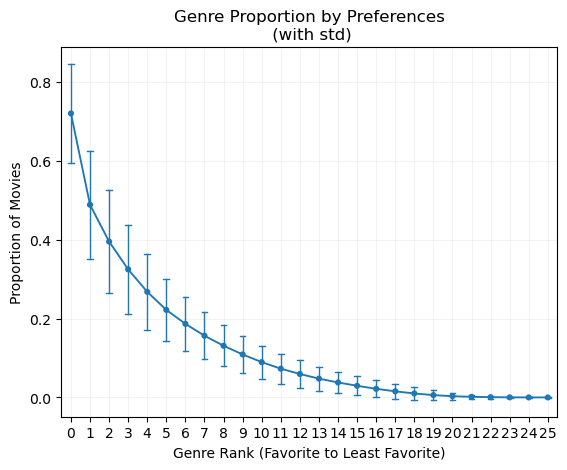

In [10]:
# Sort genres for each actor from favorite to least favorite
actor_genre_proportion_arr = actor_genre_proportion.to_numpy()
genre_favorites_prop=np.sort(actor_genre_proportion_arr, axis=1)[:, ::-1]

sns.pointplot(
    data=genre_favorites_prop,
    errorbar="sd",  # Show error bars based on standard deviation
    scale=0.5,
    capsize=0.3,
    errwidth=1,
)
plt.title("Genre Proportion by Preferences\n (with std)")
plt.xlabel("Genre Rank (Favorite to Least Favorite)")
plt.ylabel("Proportion of Movies")
plt.grid(alpha=0.15)
plt.show()

In [11]:

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

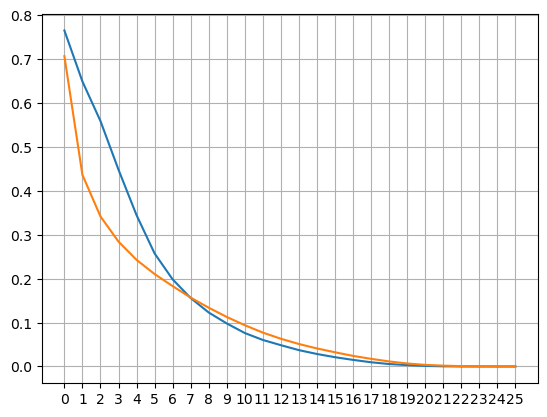

In [29]:
kmeans = KMeans(n_clusters=2, n_init=10).fit(genre_favorites_prop)
plt.plot(kmeans.cluster_centers_.T);
plt.xticks(np.arange(len(genreslist)));
plt.grid()

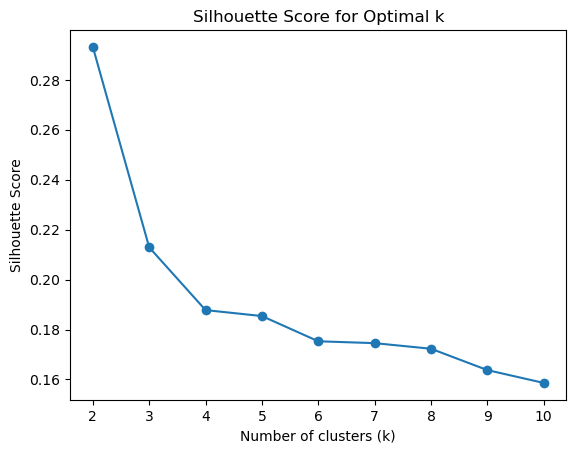

In [27]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(genre_favorites_prop)
    silhouette_scores.append(silhouette_score(genre_favorites_prop, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [12]:
test = (actor_genre_proportion_arr- actor_genre_proportion_arr.mean(axis=0))/ actor_genre_proportion_arr.std(axis=0)

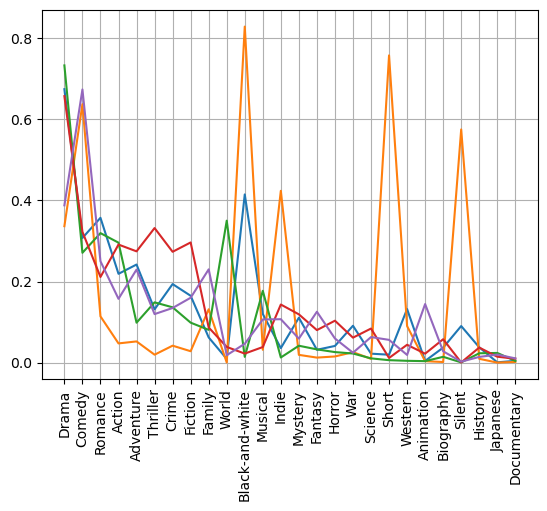

In [13]:
kmeans = KMeans(n_clusters=5, n_init=10).fit(actor_genre_proportion_arr)

# plt.figure(figsize=(20,10))
# for i in range(len(kmeans.cluster_centers_)):
#     plt.subplot(len(kmeans.cluster_centers_),1, i+1)
#     plt.plot(kmeans.cluster_centers_.T[:,i]*actor_genre_proportion_arr.std(axis=0) + actor_genre_proportion_arr.mean(axis=0))
#     plt.xticks(np.arange(len(genreslist)),genreslist, rotation=90)
#     #plt.legend(labels=np.arange(len(kmeans.cluster_centers_)))
plt.plot(kmeans.cluster_centers_.T);
plt.xticks(np.arange(len(genreslist)),genreslist, rotation=90);
plt.grid()

In [14]:
np.unique(kmeans.predict(test), return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 505,  336,  964, 1175,  889]))

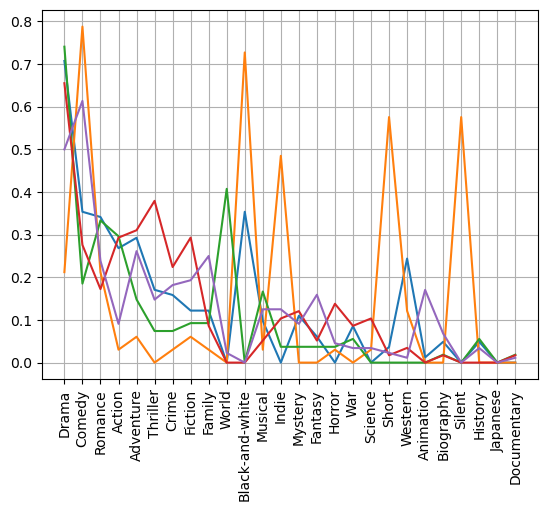

In [15]:
from scipy.spatial.distance import cdist
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(actor_genre_proportion_arr, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = actor_genre_proportion_arr[cluster_medoids]

plt.plot(medoid_profile_sequences.T);
plt.xticks(np.arange(len(genreslist)),genreslist, rotation=90);
plt.grid()

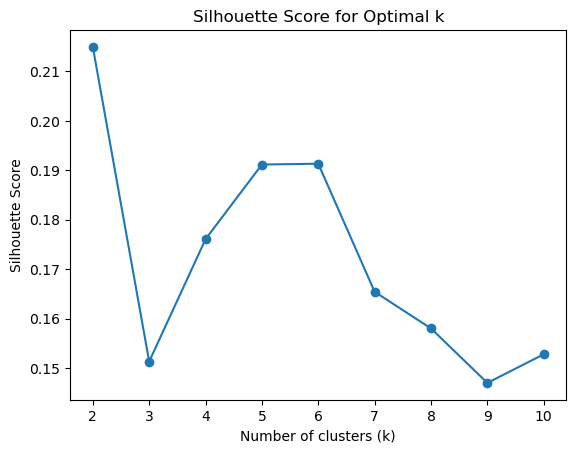

In [16]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(actor_genre_proportion_arr)
    silhouette_scores.append(silhouette_score(actor_genre_proportion_arr, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [17]:
agg_clu = AgglomerativeClustering(n_clusters=5)
clustering = agg_clu.fit(actor_genre_proportion_arr)
np.unique(clustering.labels_, return_counts=True)


(array([0, 1, 2, 3, 4]), array([1414,  521,  670, 1182,   82]))

In [18]:
agg_clu

AgglomerativeClustering(n_clusters=5)

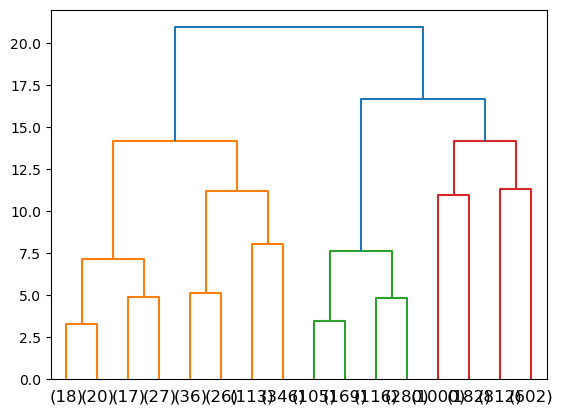

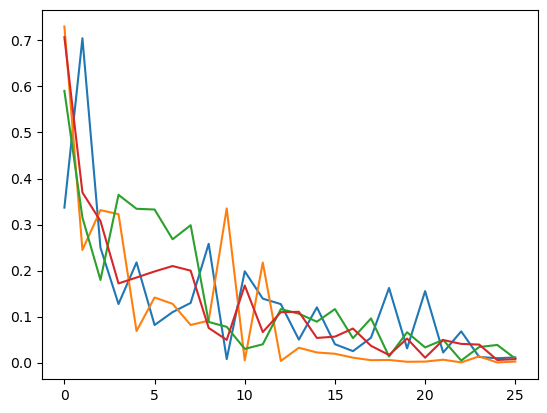

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Assume you have an array 'actor_genre_proportion_arr'
# Calculate the linkage matrix
linkage_matrix = linkage(actor_genre_proportion_arr, method='ward')  # You can use different linkage methods

# Plot the dendrogram
dendrogram(linkage_matrix, truncate_mode="level", p=3)

# Determine clusters based on a distance threshold or the number of clusters
threshold = 12  # You can adjust this threshold according to your data
clusters = fcluster(linkage_matrix, criterion='maxclust', t=4)

# Calculate cluster means
unique_clusters = np.unique(clusters)
cluster_means = np.zeros((len(unique_clusters), actor_genre_proportion_arr.shape[1]))

for i, cluster in enumerate(unique_clusters):
    cluster_means[i, :] = np.mean(actor_genre_proportion_arr[clusters == cluster, :], axis=0)

plt.figure()
plt.plot(cluster_means.T)
# Show the plot
plt.show()


# Normalisé

Text(0, 0.5, 'Frequency')

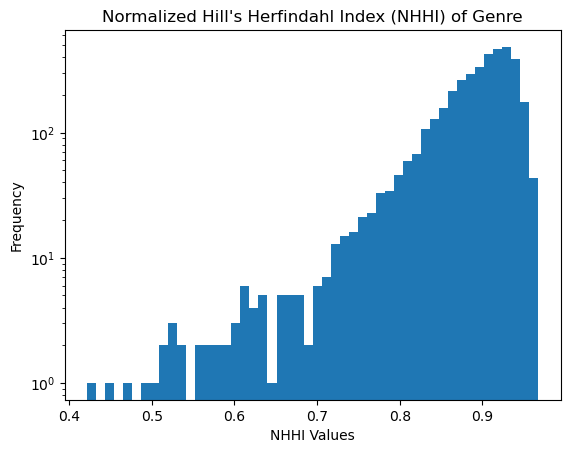

In [20]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Normalize genre occurrences by dividing each genre count by the total number of genres in movies
genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

# Group by actor and aggregate data, summing up occurrences of each genre
actor_genre_counts = genre_dummies.groupby("fbActorID").agg(
    {"fbID": lambda x: np.unique(x), **{genre: "sum" for genre in genreslist}}
)



# Calculate the number of movies with genres for each actor 
actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# Calculate the percentage of each genre for each actor 
actor_genre_percentage = actor_genre_counts[genreslist].div(
    actor_genre_counts["numMoviesWithGenre"], axis=0
)

# Convert the actor_genre_percentage DataFrame to numpy arrays for further calculations
genres_perc = actor_genre_percentage.to_numpy()
num_genres_explored = np.count_nonzero(actor_genre_percentage,axis=1)

# Calculate Normalized Hill's Herfindahl Index (NHHI) to measure diversity in genre preferences
NHHI = 1 - ((genres_perc**2).sum(axis=1) - 1 / 26) / (1 - 1 / 26)

# # Convert the actor_genre_percentage DataFrame to numpy arrays for further calculations
# genres_perc = actor_genre_percentage.to_numpy()
# num_film = actor_genre_counts["numMoviesWithGenre"].to_numpy()

# # Calculate Normalized Hill's Herfindahl Index (NHHI) to measure diversity in genre preferences
# NHHI = 1 - ((genres_perc**2).sum(axis=1) - 1 / num_film) / (1 - 1 / num_film)

plt.hist(NHHI, bins=50)
plt.yscale("log")
plt.title("Normalized Hill's Herfindahl Index (NHHI) of Genre")
plt.xlabel("NHHI Values")
plt.ylabel("Frequency")

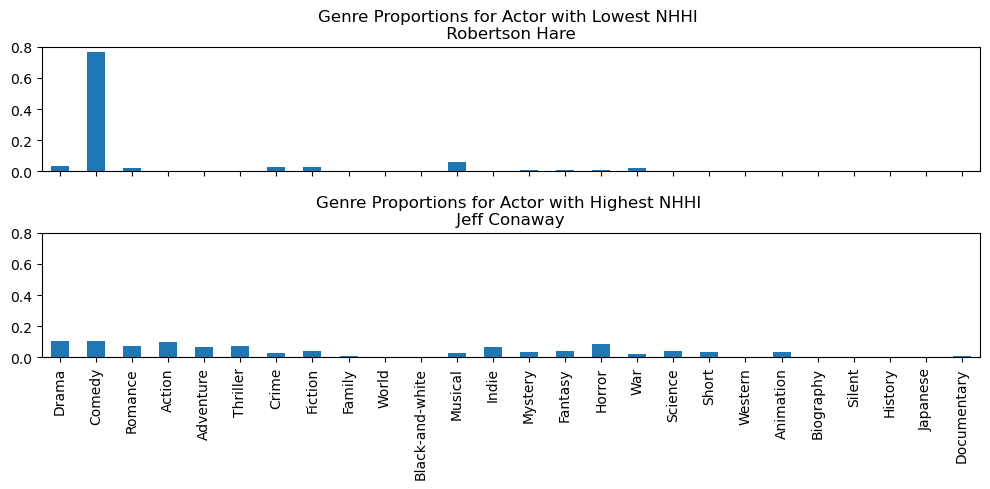

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot genre proportions for the actor with the lowest NHHI value
actor_genre_percentage.iloc[np.argmin(NHHI)].plot(kind="bar", ax=ax1)
ax1.set_ylim(0, 0.8)
ax1.set_title(
    f"Genre Proportions for Actor with Lowest NHHI \n {actors[actors['fbActorID']==actor_genre_percentage.iloc[np.argmin(NHHI)].name].actorName.item()} "
)

# Plot genre proportions for the actor with the highest NHHI value
actor_genre_percentage.iloc[np.argmax(NHHI)].plot(kind="bar", ax=ax2)
ax2.set_ylim(0, 0.8)
ax2.set_title(
    f"Genre Proportions for Actor with Highest NHHI \n {actors[actors['fbActorID']==actor_genre_percentage.iloc[np.argmax(NHHI)].name].actorName.item()} "
)
ax2.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

In [22]:
actors[actors["actorName"] == "Jackie Condon"]

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies
21076,/m/04jzg4,Jackie Condon,M,1918-03-25,NaN,NaN,1918.0,"[/m/02z8y3_, /m/02zbg3p, /m/03c053j, /m/03hk08...","{'/m/02z8y3_': 8.0, '/m/02zbg3p': 9.0, '/m/03c...",NaN,NaN,24


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(
    data=movies.explode("genres"), kind="bar",
    x="genres", y="averageRating",
    errorbar="ci", palette="dark", alpha=.6,aspect=3,  # Increase the height value
)
plt.xticks(rotation=90)
plt.show()


KeyboardInterrupt: 

Drama PearsonRResult(statistic=-0.03289879236043604, pvalue=0.0407327805946848)
Comedy PearsonRResult(statistic=-0.06690030336770163, pvalue=3.118902735025551e-05)
Romance PearsonRResult(statistic=0.028418401799812077, pvalue=0.07715341405025382)
Action PearsonRResult(statistic=0.2771769945131932, pvalue=3.4587037665789714e-69)
Adventure PearsonRResult(statistic=0.48239557369566477, pvalue=9.969087204528455e-225)
Thriller PearsonRResult(statistic=0.4695727399883657, pvalue=1.8371576647618304e-211)
Crime PearsonRResult(statistic=0.4387346811954021, pvalue=8.66942417070614e-182)
Fiction PearsonRResult(statistic=0.4997727773332117, pvalue=1.2427199860798122e-243)
Family PearsonRResult(statistic=0.02223221388711584, pvalue=0.166788676639995)
World PearsonRResult(statistic=-0.09638441698441166, pvalue=1.886526781359569e-09)
Black-and-white PearsonRResult(statistic=0.017272903364346205, pvalue=0.2827645268398695)
Musical PearsonRResult(statistic=-0.11493809056852473, pvalue=7.458138465037236

/var/folders/zb/93_wdkq15c59q4mk_nb7d79c0000gn/T/ipykernel_61639/4159728878.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


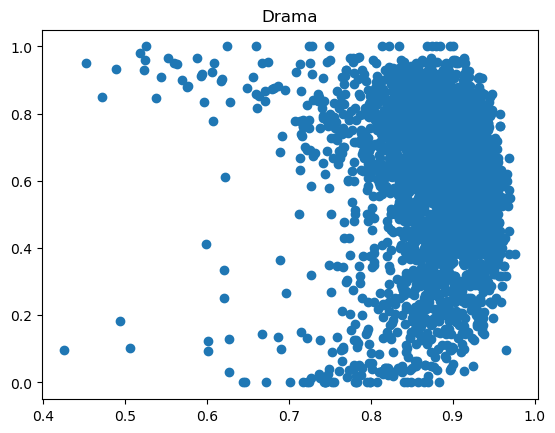

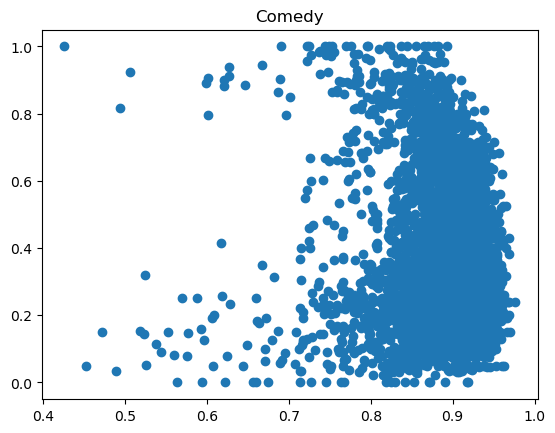

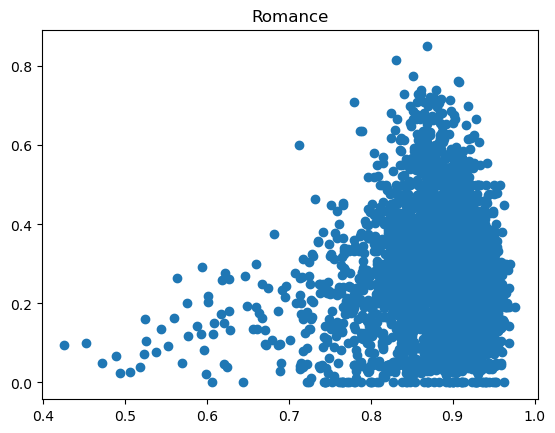

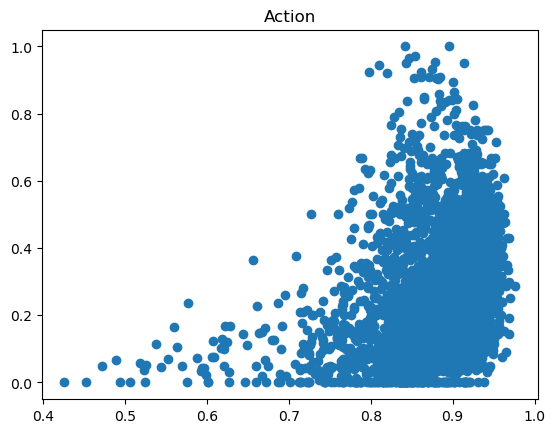

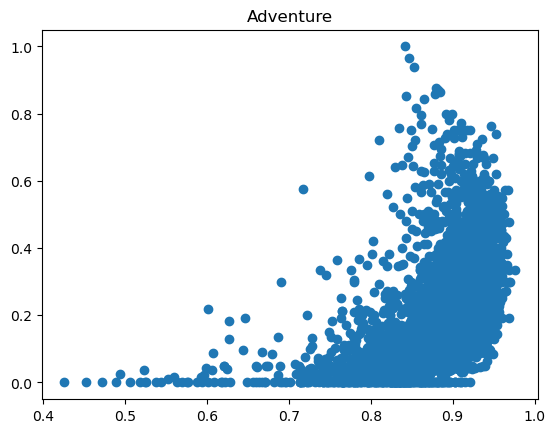

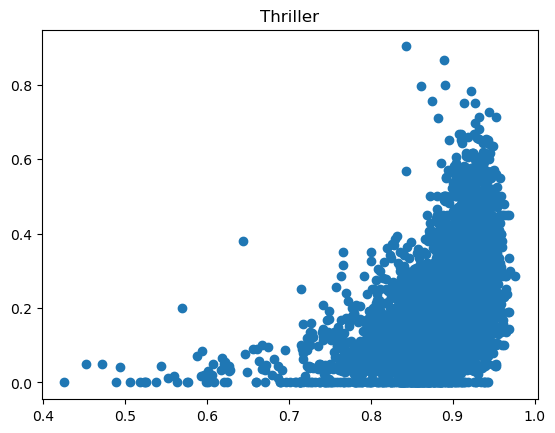

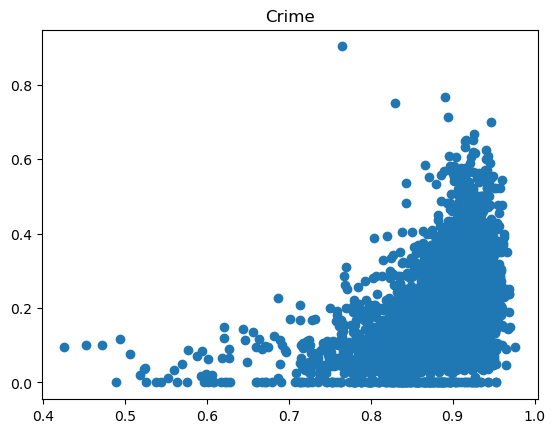

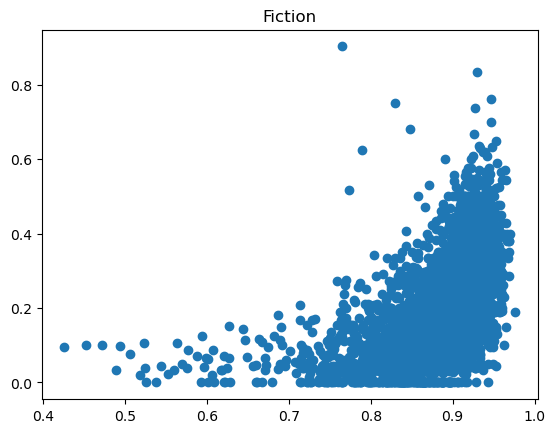

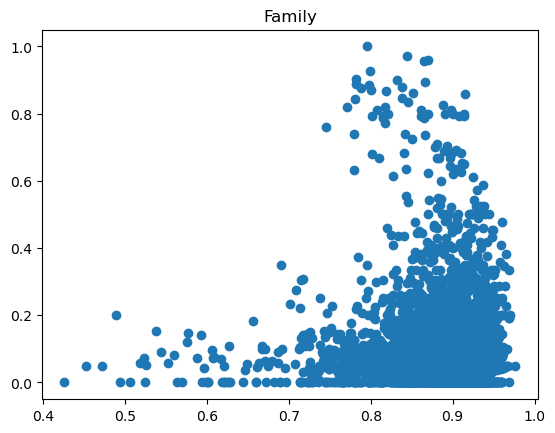

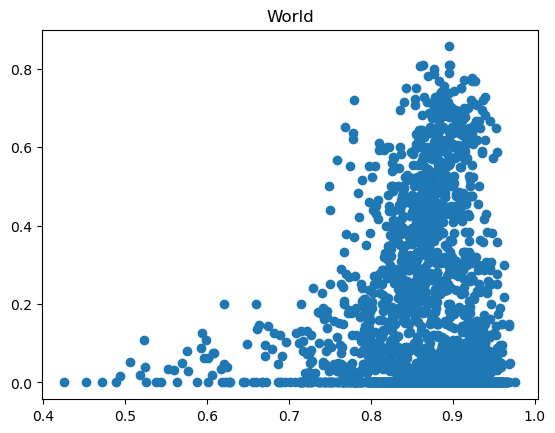

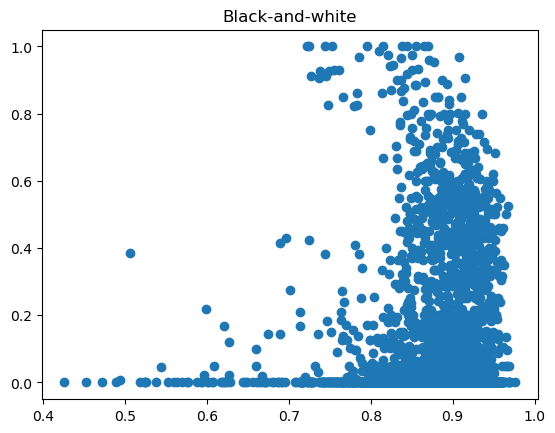

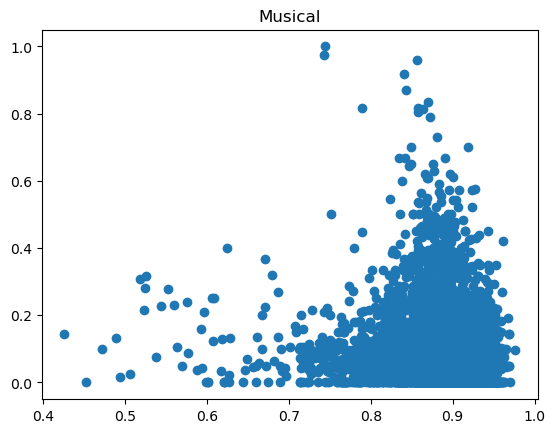

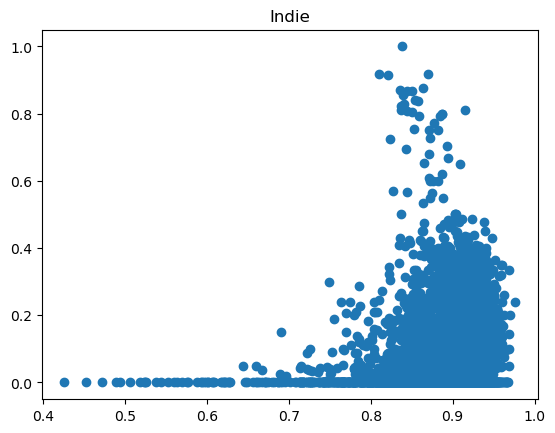

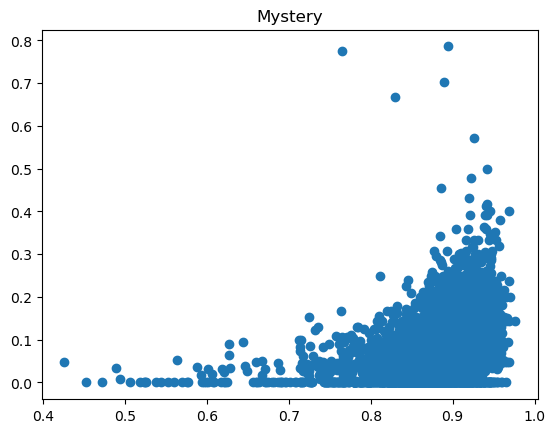

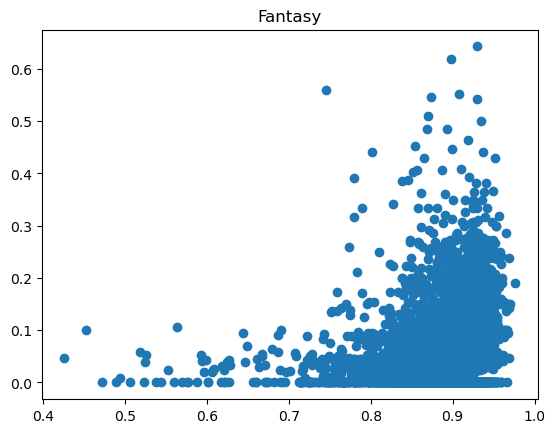

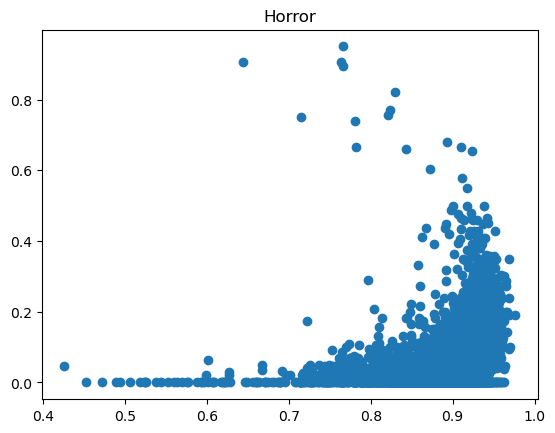

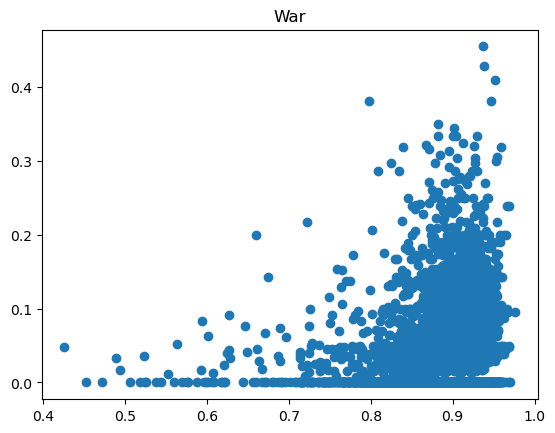

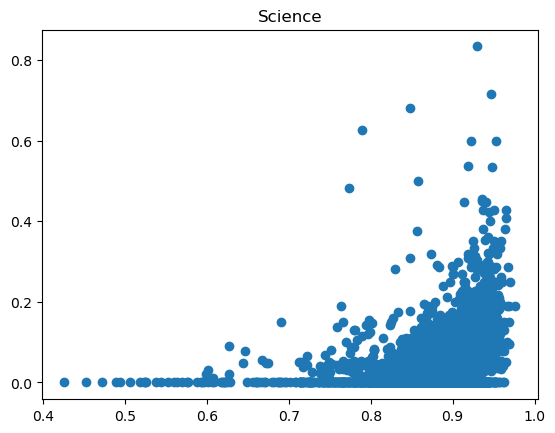

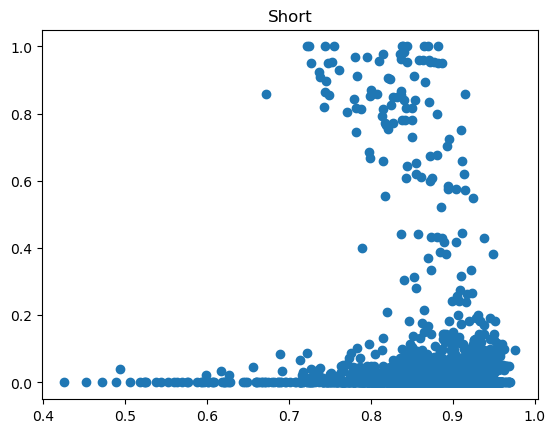

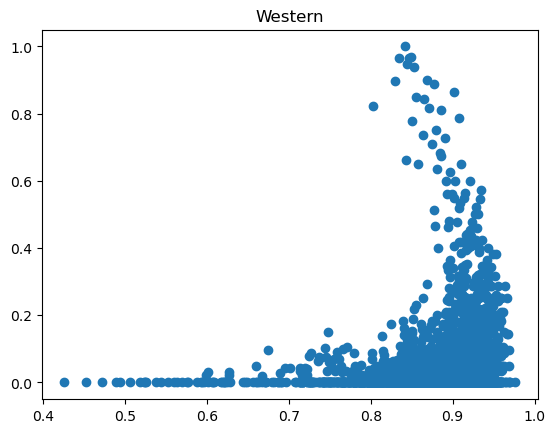

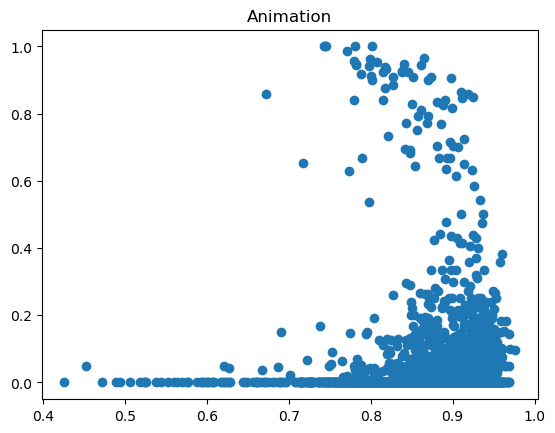

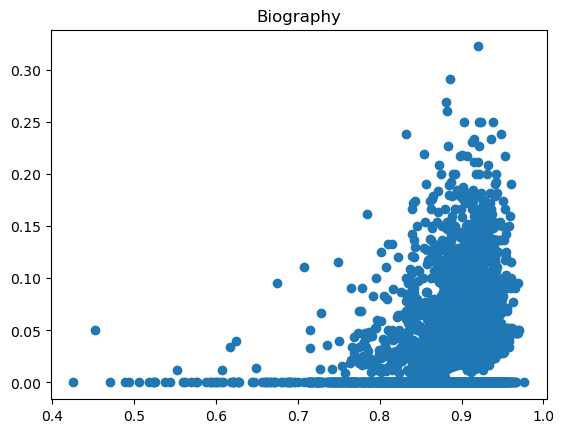

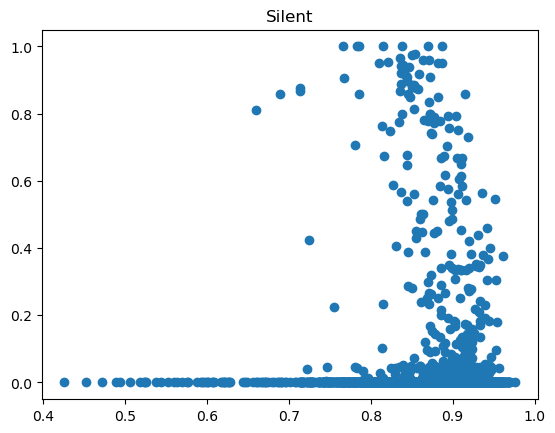

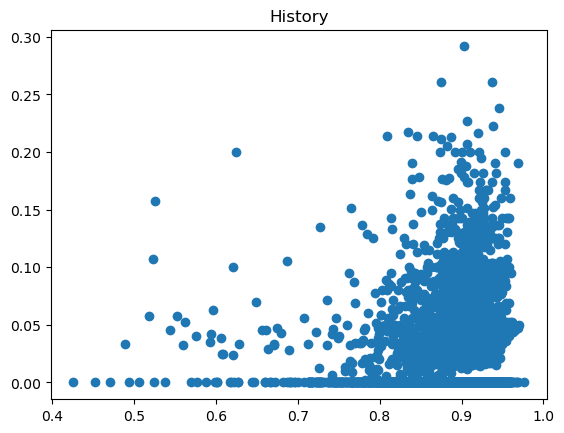

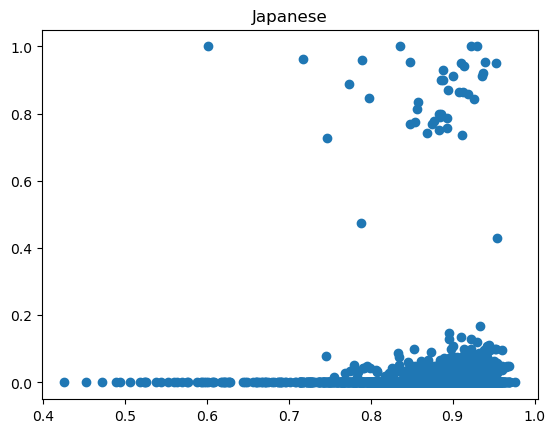

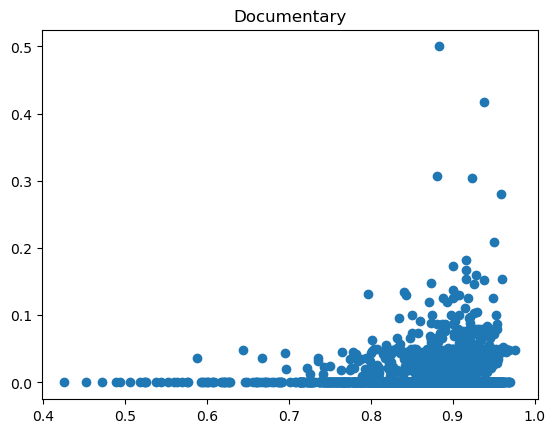

In [ ]:
for col in actor_genre_percentage.columns:
    print(col, scipy.stats.pearsonr(actor_genre_proportion[col], NHHI))
    plt.figure()
    plt.scatter(NHHI,actor_genre_proportion[col])
    plt.title(col)

# NHHI EVOLUTION

In [ ]:
actors_movies = actors_exp.merge(
    movies[["fbID", "genres", "releaseMonth", "releaseYear"]], how="left", on="fbID"
)
actors_sort = actors_movies.sort_values(
    by=["fbActorID", "ageAtMovieRelease", "releaseYear", "releaseMonth"]
)
actors_sort = actors_sort[
    ~(actors_sort.ageAtMovieRelease.isna() & actors_sort.releaseYear.isna())
    & ~actors_sort.genres.isna()
]

actors_sort["genresLen"] = actors_sort.genres.apply(lambda x: len(x))
actors_sort["LastMovie"] = np.array(
    [
        *(
            actors_sort.fbActorID[1:].values
            != actors_sort.fbActorID.values[:-1]
        ),
        True,
    ]
)
exploded_actors_genres = actors_sort.explode("genres")

In [ ]:
#actors_sort.groupby(["fbActorID", "ageAtMovieRelease"]).agg({"genres": lambda x: list(x)})

genres
fbActorID ageAtMovieRelease                                                   
/m/010p3  33.0                                             [{Comedy, Romance}]
          34.0                                             [{Comedy, Romance}]
          35.0               [{Comedy, Romance, Drama}, {Comedy, Indie, Rom...
          38.0                                                      [{Comedy}]
          42.0                                      [{Comedy, Indie, Romance}]
...                                                                        ...
/m/0zcbl  43.0               [{Comedy, Drama}, {Comedy, Family, Indie, Dram...
          44.0               [{Thriller, Drama}, {Comedy, Thriller, Fiction...
          45.0                             [{Comedy, Musical, Romance, Drama}]
          46.0                       [{Comedy, Adventure, Animation}, {Drama}]
/m/0zjpz  49.0                             [{Biography, Musical, Documentary}]

[208056 rows x 1 columns]

In [ ]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "ageAtMovieRelease", "genres", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

In [ ]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

genre_dummies

,fbActorID,genresLen,fbID,Action,Adventure,Animation,Biography,Black-and-white,Comedy,Crime,...,Musical,Mystery,Romance,Science,Short,Silent,Thriller,War,Western,World
3,/m/010p3,2,/m/06c5z_,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/m/010p3,2,/m/06c5z_,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,/m/010p3,2,/m/0b6jfrc,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,/m/010p3,2,/m/0b6jfrc,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,/m/010p3,3,/m/08hjr9,0.0,0.0,0.000000,0.000000,0.0,0.333333,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446020,/m/0zcbl,3,/m/0gkyxjc,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446023,/m/0zcbl,1,/m/0k3lpxc,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446027,/m/0zjpz,3,/m/05sqdmg,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446027,/m/0zjpz,3,/m/05sqdmg,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
genre_actor_len = (
    actors_min_movies.explode("genres")
    .groupby("fbActorID")[["genres", "numMovies"]]
    .aggregate(
        {"genres": (lambda x: (len(set(x)))), "numMovies": (lambda x: int(np.mean(x)))}
    )
)

In [ ]:
mod = smf.ols(formula='numMovies ~  genres', data=genre_actor_len)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              numMovies   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     230.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.27e-50
Time:                        11:14:42   Log-Likelihood:                -17667.
No. Observations:                3869   AIC:                         3.534e+04
Df Residuals:                    3867   BIC:                         3.535e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1562      1.953      4.176      0.0

In [ ]:
scipy.stats.pearsonr(genre_actor_len.genres,genre_actor_len.numMovies)

PearsonRResult(statistic=0.23720516348821924, pvalue=1.2667334225440596e-50)

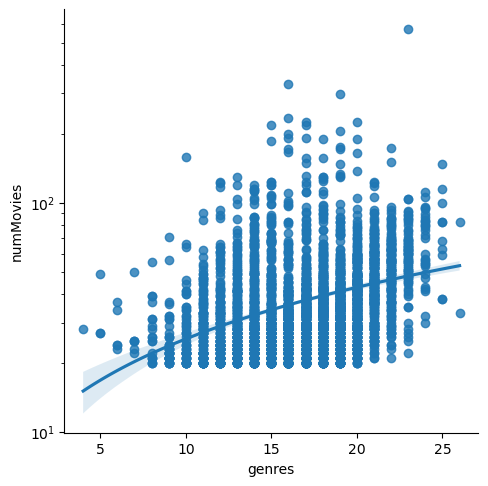

In [ ]:
sns.lmplot(genre_actor_len, x="genres", y="numMovies")
plt.yscale("log")